In [1]:
# @title
import matplotlib.pyplot as plt
import numpy as np
import cmath
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from Functions import *

In [2]:
#============== System parameters
Nt = 1
nIRSrow = 10
nIRScol = nIRSrow
Ns = nIRSrow*nIRScol
K = 6                 # USERS
# gamma = db2pow(20)
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10
noise = -133 # -174+10*np.log10(BW) + NF

GRID_RADIUS = 1000
BASE_STATION_POSITION = (0, 0, 20)
TRANSMIT_POWER_WATTS = 0.1 #in watts
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
# FADING_STD_DEV = 3
PATH_LOSS_EXPONENT = 2.2 #path loss exponent (direct)
BETA = 3.8 #path loss exponent (indirect)
ZETA = 3.8
m = 1
omega = np.sqrt(0.5)

B = 4

IRS_POSITION_1 = (30, 40, 10) #(15, 20, 10) better than (300, 400, 10)
IRS_POSITION_2 = (30, -40, 10)

# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # in dBm
# Pt = 10 * np.log10(TRANSMIT_POWER_WATTS) + 30 # in dBm
# Pb = 10 # in dBw
# Pu = 10 # in dBm

NUM_SIMULATIONS = 50

h_dk_3d = []
h_rk_3d = []
h_rk_transpose_3d = []
G_3d = []
h_dk_2_3d = []
h_rk_2_3d = []
h_rk_transpose_2_3d = []
G_2_3d = []
# h_dk_3_3d = []
# h_rk_3_3d = []
# h_rk_transpose_3_3d = []
# G_3_3d = []
# h_dk_4_3d = []
# h_rk_4_3d = []
# h_rk_transpose_4_3d = []
# G_4_3d = []

In [3]:
# @title
# Generate antennas position
AP_position = generate_station_positions_3D(BASE_STATION_POSITION)
xt, yt, zt = AP_position[0]

# Generate IRS position_1
irs_position_1 = generate_IRS_3D(IRS_POSITION_1)
xs_1, ys_1, zs_1 = irs_position_1[0]

# Generate IRS position_2
irs_position_2 = generate_IRS_3D(IRS_POSITION_2)
xs_2, ys_2, zs_2 = irs_position_2[0]

tx_ant_coords = generate_transmit_antenna_coordinates_3D(Nt, xt, yt, zt, halfLambda, quarterLambda)
loc_T = tx_ant_coords
# print('Transmit antenna(e) coordinates:'"\n", loc_T)
# print()

irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_1 = irs_coords_1
# print('IRS 1 elements coordinates:'"\n", loc_S_1)
# print()

irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_2 = irs_coords_2
# print('IRS 2 elements coordinates:'"\n", loc_S_2)
# print()

In [4]:
# Perform simulations
Direct_link_users = int(K/3)
for i in range(NUM_SIMULATIONS):

    # USERS to BS - DIRECT LINK
    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk1 = []
    fading1 = []
    for user in range(Direct_link_users):
        fading1.append(generate_rayleigh_fading_channel(Nt, FADING_STD_MEAN, FADING_STD_DEV))
    h_dk1 = np.array(fading1)
    h_dk1 = h_dk1.reshape(Nt,2)
    #h_dk1 = np.array(h_dk1)
    h_dk_3d.append(h_dk1)

    # FIRST IRS to USERS
    # Generate the Nakagami Channel from each user to the IRS (h_rk)
    h_rk1 = []
    fading2 = []
    for user in range(K):
        fading2.append(generate_nakagami_samples(m, omega, Ns))
    h_rk1 = np.array(fading2)
    h_rk1 = h_rk1.reshape(Ns,K)
    h_rk_3d.append(h_rk1)

    h_rk_conj1 = np.conj(h_rk1)
    h_rk_transpose1 = np.transpose(h_rk_conj1)
    h_rk_transpose_3d.append(h_rk_transpose1)

    # FIRST IRS to BS
    # Generate the Nakagami Channel from base_station to the IRS (G)
    G1 = []
    fading3 = []
    for element in range(Ns):
        fading3.append(generate_nakagami_samples(m, omega, Nt))
    G1 = np.array(fading3)
    G_3d.append(G1)

    # # Generate the Rayleigh Fading Channel for each user (h_dk)
    # h_dk2 = []
    # fading4 = []
    # for user in range(K):
    #     fading4.append(generate_rayleigh_fading_channel(Nt, FADING_STD_MEAN, FADING_STD_DEV))
    # h_dk2 = np.array(fading4)
    # h_dk2 = h_dk2.reshape(Nt, K)
    # h_dk_2_3d.append(h_dk2)

    # SECOND IRS to USERS
    # Generate the Nakagami Channel from each user to the IRS (h_rk)
    h_rk2 = []
    fading5 = []
    for user in range(K):
        fading5.append(generate_nakagami_samples(m, omega, Ns))
    h_rk2 = np.array(fading5)
    h_rk2 = h_rk2.reshape(Ns, K)
    h_rk_2_3d.append(h_rk2)

    h_rk_conj2 = np.conj(h_rk2)
    h_rk_transpose2 = np.transpose(h_rk_conj2)
    h_rk_transpose_2_3d.append(h_rk_transpose2)

    # SECOND IRS to BS
    # Generate the Nakagami Channel from base_station to the IRS (G)
    G2 = []
    fading6 = []
    for element in range(Ns):
        fading6.append(generate_nakagami_samples(m, omega, Nt))
    G2 = np.array(fading6)
    G_2_3d.append(G2)

    # # Generate the Rayleigh Fading Channel for each user (h_dk)
    # h_dk3 = []
    # fading7 = []
    # for user in range(K):
    #     fading7.append(generate_rayleigh_fading_channel(Nt, FADING_STD_MEAN, FADING_STD_DEV))
    # h_dk3 = np.array(fading7)
    # h_dk3 = h_dk3.reshape(Nt, K)
    # h_dk_3_3d.append(h_dk3)

    # # Generate the Nakagami Channel from each user to the IRS (h_rk)
    # h_rk3 = []
    # fading8 = []
    # for user in range(K):
    #     fading8.append(generate_nakagami_samples(m, omega, Ns))
    # h_rk3 = np.array(fading8)
    # h_rk3 = h_rk3.reshape(Ns, K)
    # h_rk_3_3d.append(h_rk3)

    # h_rk_conj3 = np.conj(h_rk3)
    # h_rk_transpose3 = np.transpose(h_rk_conj3)
    # h_rk_transpose_3_3d.append(h_rk_transpose3)

    # # Generate the Nakagami Channel from base_station to the IRS (G)
    # G3 = []
    # fading9 = []
    # for element in range(Ns):
    #     fading9.append(generate_nakagami_samples(m, omega, Nt))
    # G3 = np.array(fading9)
    # G_3_3d.append(G3)

    # # Generate the Rayleigh Fading Channel for each user (h_dk)
    # h_dk4 = []
    # fading10 = []
    # for user in range(K):
    #     fading10.append(generate_rayleigh_fading_channel(Nt, FADING_STD_MEAN, FADING_STD_DEV))
    # h_dk4 = np.array(fading10)
    # h_dk4 = h_dk4.reshape(Nt, K)
    # h_dk_4_3d.append(h_dk4)

    # # Generate the Nakagami Channel from each user to the IRS (h_rk)
    # h_rk4 = []
    # fading11 = []
    # for user in range(K):
    #     fading11.append(generate_nakagami_samples(m, omega, Ns))
    # h_rk4 = np.array(fading11)
    # h_rk4 = h_rk4.reshape(Ns, K)
    # h_rk_4_3d.append(h_rk4)

    # h_rk_conj4 = np.conj(h_rk4)
    # h_rk_transpose4 = np.transpose(h_rk_conj4)
    # h_rk_transpose_4_3d.append(h_rk_transpose4)

    # # Generate the Nakagami Channel from base_station to the IRS (G)
    # G4 = []
    # fading12 = []
    # for element in range(Ns):
    #     fading12.append(generate_nakagami_samples(m, omega, Nt))
    # G4 = np.array(fading12)
    # G_4_3d.append(G4)

In [5]:
# @title
# Generate antennas position
AP_position = generate_station_positions_3D(BASE_STATION_POSITION)
xt, yt, zt = AP_position[0]

# Generate IRS position_1
irs_position_1 = generate_IRS_3D(IRS_POSITION_1)
xs_1, ys_1, zs_1 = irs_position_1[0]

# Generate IRS position_2
irs_position_2 = generate_IRS_3D(IRS_POSITION_2)
xs_2, ys_2, zs_2 = irs_position_2[0]

tx_ant_coords = generate_transmit_antenna_coordinates_3D(Nt, xt, yt, zt, halfLambda, quarterLambda)
loc_T = tx_ant_coords
# print('Transmit antenna(e) coordinates:'"\n", loc_T)
# print()

irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_1 = irs_coords_1
# print('IRS 1 elements coordinates:'"\n", loc_S_1)
# print()

irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_2 = irs_coords_2
# print('IRS 2 elements coordinates:'"\n", loc_S_2)
# print()

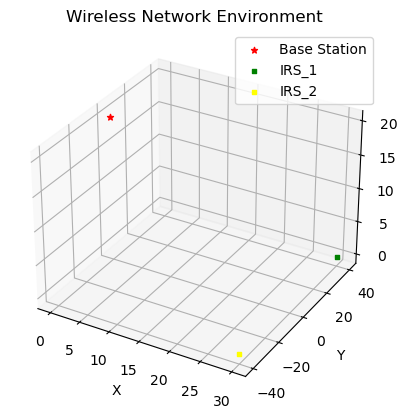

In [6]:
# @title
# Plot the 3D grid, base station, IRS, and user positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(IRS_POSITION_1[0], IRS_POSITION_1[1], IRS_POSITION_1[2], color='green', marker='s', label='IRS_1')
plt.scatter(IRS_POSITION_2[0], IRS_POSITION_2[1], IRS_POSITION_2[2],color='yellow', marker='s', label='IRS_2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Wireless Network Environment')
ax.legend()
ax.grid(True)


In [23]:
qB = np.arange(1,4,1)
user_distances = np.arange(27, 1000, 30) # in m
#print("user_distances: ", user_distances)

# Direct link considered for users < 25m or 1/40 of Grid Radius

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}

for B in qB:

    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for d in user_distances:

        user_positions = [(d/40.5, 5, 0), (d/40, -5, 0), (d*0.96, 5, 0), (d*0.975, -5, 0), (d*0.98, 5, 0), (d*0.99, -5, 0)]
        user_positions = np.array(user_positions)
        loc_U = user_positions
        #print("user_positions: ", user_positions)

        dTU_1, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU_2, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)

        # Reshapiing the distance from antennas/BS to user
        dTU_1 = dTU_1.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Reshapiing the distance from antennas/BS to user
        dTU_2 = dTU_2.reshape(Nt,K)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        h_rk_2_ns_values = [h_rk_2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G_ns_2_values = [G_2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, Direct link users)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)

            h_rk_2 = h_rk_2_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose_2 = np.transpose(np.conj(h_rk_2))  # Shape: (K, Ns)
            G_2 = G_ns_2_values[s]  # Shape: (Ns, 1)
            desired_shape = (1, K)
            num_zeros_to_append = desired_shape[1] - h_dk.shape[1]
            h_dk = np.pad(h_dk, ((0, 0), (0, num_zeros_to_append)), mode='constant', constant_values=0)

            h_dk_zero = np.zeros((1, 6))


            results_array_1 = results_array_sharing_ideal(K, Ns, Nt, h_dk, h_rk, h_rk_transpose, G)
            results_array_2 = results_array_sharing_ideal(K, Ns, Nt, h_dk_zero, h_rk_2 ,h_rk_transpose_2, G_2)
            # results_array_1 shape(1, K)


            link_inter = []

            # Direct link considered
            for i in range(Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/(np.sqrt((dTU_1[0][i])**ZETA))) + ((results_array_1[0][i])/(np.sqrt((dSU_1[0][i])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))) + ((results_array_2[0][i])/(np.sqrt((dSU_2[0][i])**PATH_LOSS_EXPONENT * (dTS_2)**BETA))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # Direct link not conisdered
            for i in range(K - Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((0)/(np.sqrt((dTU_1[0][i+Direct_link_users])**ZETA))) + ((results_array_1[0][i+Direct_link_users])/(np.sqrt((dSU_1[0][i+Direct_link_users])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))) + ((results_array_2[0][i+Direct_link_users])/(np.sqrt((dSU_2[0][i+Direct_link_users])**PATH_LOSS_EXPONENT * (dTS_2)**BETA))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)

            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30
            link_budget = link_budget.reshape(1,K)
            # print(link_budget)

            #Calculate the noise value
            # noise = -133 # in dBm

            SNR_matrix = []

            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)

            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)

            # Calculate rate
            rate_matrix = BW * compute_rate((SNR_matrix))
            # print(rate_matrix)
            rate_matrix_new = rate_matrix.flatten()
            # print(rate_matrix_new)
            sum_rate_N = np.sum(rate_matrix_new)
            sum_rate.append(sum_rate_N)
            # print(sum_rate_N)

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(sum_rate_N, P)
            energy_efficiency.append(ee/10e6)

        # Compute average energy efficiency for the current N
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # Append sum-rate for this T to the list
        sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))

    # Store the results in the dictionary with N as the key
    results_dict_1[B] = sum_rates_1

    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1

# print('done')
# print("dTU_1: ", dTU_1)
# print("dTU_1 shape: ", dTU_1.shape)
# print("dTU_2: ", dTU_2)
# print("dTU_2 shape: ", dTU_2.shape)
# print("h_dk shape: ", np.shape(h_dk))
# print("h_rk shape: ", h_rk.shape)
# print("G shape: ", G.shape)

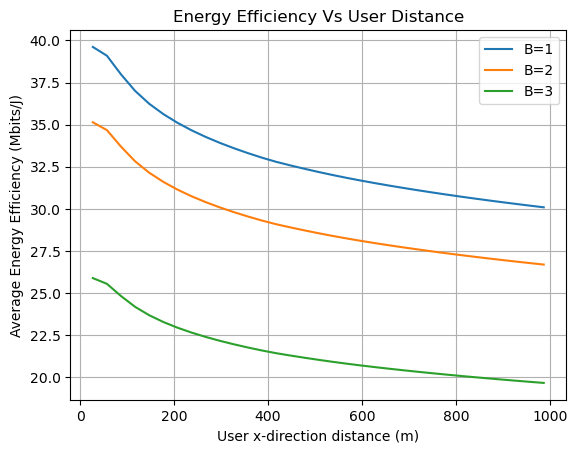

In [24]:
# @title
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(user_distances, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('User x-direction distance (m)')
plt.title('Energy Efficiency Vs User Distance')
plt.legend()
plt.grid(True)
plt.show()

# **RESULT ARRAY SHARING PRACTICAL**

In [25]:
beta_min = 0.2
k = 1.6
phi = 0.43 * np.pi

# Initialize an empty dictionary to store the results
results_dict_3 = {}
results_dict_4 = {}

for B in qB:

    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for d in user_distances:

        user_positions = [(d/40.5, 5, 0), (d/40, -5, 0), (d*0.96, 5, 0), (d*0.975, -5, 0), (d*0.98, 5, 0), (d*0.99, -5, 0)]
        user_positions = np.array(user_positions)
        loc_U = user_positions

        dTU_1, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU_2, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)

        # Reshapiing the distance from antennas/BS to user
        dTU_1 = dTU_1.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Reshapiing the distance from antennas/BS to user
        dTU_2 = dTU_2.reshape(Nt,K)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        h_rk_2_ns_values = [h_rk_2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G_ns_2_values = [G_2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)

            h_rk_2 = h_rk_2_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose_2 = np.transpose(np.conj(h_rk_2))  # Shape: (K, Ns)
            G_2 = G_ns_2_values[s]  # Shape: (Ns, 1)

            num_zeros_to_append = desired_shape[1] - h_dk.shape[1]
            h_dk = np.pad(h_dk, ((0, 0), (0, num_zeros_to_append)), mode='constant', constant_values=0)
            h_dk_zero = np.zeros((1, 6))
            #print("h_dk shape ", h_dk.shape)

            results_array_1 = results_array_sharing_practical(K, Ns, Nt, h_dk, h_rk, h_rk_transpose, G, B, beta_min, phi, k)
            results_array_2 = results_array_sharing_practical(K, Ns, Nt, h_dk_zero, h_rk_2, h_rk_transpose_2, G_2, B, beta_min, phi, k)

            link_inter = []

            # Direct link considered
            for i in range(Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/(np.sqrt((dTU_1[0][i])**ZETA))) + ((results_array_1[0][i])/(np.sqrt((dSU_1[0][i])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))) + ((results_array_2[0][i])/(np.sqrt((dSU_2[0][i])**PATH_LOSS_EXPONENT * (dTS_2)**BETA))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # Direct link not conisdered
            for i in range(K-Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((0)/(np.sqrt((dTU_1[0][i+Direct_link_users])**ZETA))) + ((results_array_1[0][i+Direct_link_users])/(np.sqrt((dSU_1[0][i+Direct_link_users])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))) + ((results_array_2[0][i+Direct_link_users])/(np.sqrt((dSU_2[0][i+Direct_link_users])**PATH_LOSS_EXPONENT * (dTS_2)**BETA))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)

            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30
            link_budget = link_budget.reshape(1,K)
            # print(link_budget)

            #Calculate the noise value
            # noise = -133 # in dBm

            SNR_matrix = []

            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)

            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)

            # Calculate rate
            rate_matrix = BW * compute_rate((SNR_matrix))
            # print(rate_matrix)
            rate_matrix_new = rate_matrix.flatten()
            # print(rate_matrix_new)
            sum_rate_N = np.sum(rate_matrix_new)
            sum_rate.append(sum_rate_N)
            # print(sum_rate_N)

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(sum_rate_N, P)
            energy_efficiency.append(ee/10e6)

        # Compute average energy efficiency for the current N
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # Append sum-rate for this T to the list
        sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))

    # Store the results in the dictionary with N as the key
    results_dict_3[B] = sum_rates_1

    # Store the results in the dictionary with N as the key
    results_dict_4[B] = average_energy_efficiency_1

print('done')
print(user_distances)

done
[ 27  57  87 117 147 177 207 237 267 297 327 357 387 417 447 477 507 537
 567 597 627 657 687 717 747 777 807 837 867 897 927 957 987]


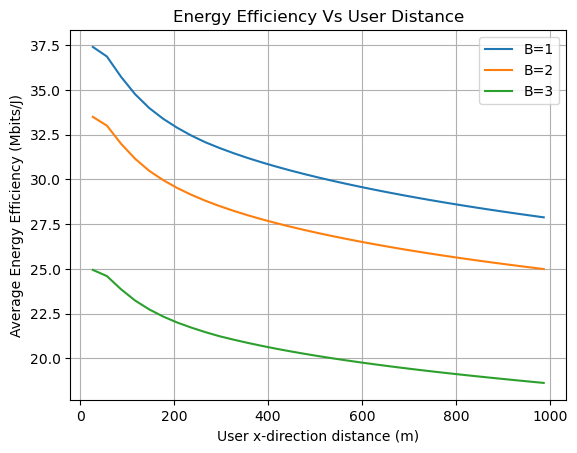

In [26]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_4.items():
    plt.plot(user_distances, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('User x-direction distance (m)')
plt.title('Energy Efficiency Vs User Distance')
plt.legend()
plt.grid(True)
plt.show()

# **SINGLE IRS CASE**

In [27]:
# Initialize an empty dictionary to store the results
results_dict_5 = {}
results_dict_6 = {}

for B in qB:

    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for d in user_distances:

        user_positions = [(d/40.5, 5, 0), (d/40, -5, 0), (d*0.96, 5, 0), (d*0.975, -5, 0), (d*0.98, 5, 0), (d*0.99, -5, 0)]
        user_positions = np.array(user_positions)
        loc_U = user_positions

        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)

        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)
            num_zeros_to_append = desired_shape[1] - h_dk.shape[1]
            h_dk = np.pad(h_dk, ((0, 0), (0, num_zeros_to_append)), mode='constant', constant_values=0)
            h_dk_zero = np.zeros((1, 6))
            #print("h_dk shape ", h_dk.shape)

            results_array = results_array_sharing_ideal(K, Ns, Nt, h_dk, h_rk, h_rk_transpose, G)

            link_inter = []

            # Direct link users ALSO considered
            for i in range(Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/(np.sqrt((dTU[0][i])**ZETA))) + ((results_array[0][i])/(np.sqrt((dSU_1[0][i])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # Indirect Link users ONLY considered
            for i in range(K-Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((0)/(np.sqrt((dTU[0][i+Direct_link_users])**ZETA))) + ((results_array[0][i+Direct_link_users])/(np.sqrt((dSU_1[0][i+Direct_link_users])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)

            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30
            link_budget = link_budget.reshape(1,K)
            # print(link_budget)

            #Calculate the noise value
            # noise = -133 # in dBm

            SNR_matrix = []

            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)

            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)

            # Calculate rate
            rate_matrix = BW * compute_rate((SNR_matrix))
            rate_matrix_new = rate_matrix.flatten()
            sum_rate_N = np.sum(rate_matrix_new)
            sum_rate.append(sum_rate_N)
            # print(sum_rate_N)

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_2 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_2 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(sum_rate_N, P)
            energy_efficiency.append(ee/10e6)

        # Compute average energy efficiency for the current N
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # Append sum-rate for this T to the list
        sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))

    # Store the results in the dictionary with N as the key
    results_dict_5[B] = sum_rates_1

    # Store the results in the dictionary with N as the key
    results_dict_6[B] = average_energy_efficiency_1

print('done')

done


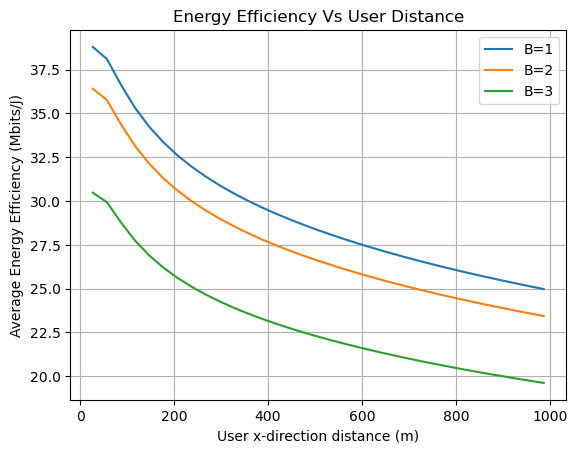

In [28]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_6.items():
    plt.plot(user_distances, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('User x-direction distance (m)')
plt.title('Energy Efficiency Vs User Distance')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Initialize an empty dictionary to store the results
results_dict_7 = {}
results_dict_8 = {}

for B in qB:

    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for d in user_distances:

        user_positions = [(d/40.5, 5, 0), (d/40, -5, 0), (d*0.96, 5, 0), (d*0.975, -5, 0), (d*0.98, 5, 0), (d*0.99, -5, 0)]
        user_positions = np.array(user_positions)
        loc_U = user_positions

        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)

        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)

        # Extract channel values for the current Ns value
        h_rk_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk = h_rk_ns_values[s]  # Shape: (Ns, K)
            h_rk_transpose = np.transpose(np.conj(h_rk))  # Shape: (K, Ns)
            G = G_ns_values[s]  # Shape: (Ns, 1)
            num_zeros_to_append = desired_shape[1] - h_dk.shape[1]
            h_dk = np.pad(h_dk, ((0, 0), (0, num_zeros_to_append)), mode='constant', constant_values=0)
            #print("h_dk shape ", h_dk.shape)

            results_array = results_array_sharing_practical(K, Ns, Nt, h_dk, h_rk, h_rk_transpose, G, B, beta_min, phi, k)

            link_inter = []

            # Direct Link ALSO Considered
            for i in range(Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][i])/(np.sqrt((dTU[0][i])**ZETA))) + ((results_array[0][i])/(np.sqrt((dSU_1[0][i])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # ONLY Indirect Link Users Considered
            for i in range(K-Direct_link_users):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((0)/(np.sqrt((dTU[0][i+Direct_link_users])**ZETA))) + ((results_array[0][i+Direct_link_users])/(np.sqrt((dSU_1[0][i+Direct_link_users])**BETA * (dTS_1)**PATH_LOSS_EXPONENT))))
                link_inter.append(link_inter_value)  # Append the computed value to the list

            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)

            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30
            link_budget = link_budget.reshape(1,K)
            # print(link_budget)

            #Calculate the noise value
            # noise = -133 # in dBm

            SNR_matrix = []

            # Calculate SNR
            for i in range(K):
                SNR = compute_SNR(link_budget[0][i], noise)
                SNR_matrix.append(SNR)

            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)

            # Calculate rate
            rate_matrix = BW * compute_rate((SNR_matrix))
            rate_matrix_new = rate_matrix.flatten()
            sum_rate_N = np.sum(rate_matrix_new)
            sum_rate.append(sum_rate_N)
            # print(sum_rate_N)

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_2 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_2 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(sum_rate_N, P)
            energy_efficiency.append(ee/10e6)

        # Compute average energy efficiency for the current N
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # Append sum-rate for this T to the list
        sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))

    # Store the results in the dictionary with N as the key
    results_dict_7[B] = sum_rates_1

    # Store the results in the dictionary with N as the key
    results_dict_8[B] = average_energy_efficiency_1

print('done')

done


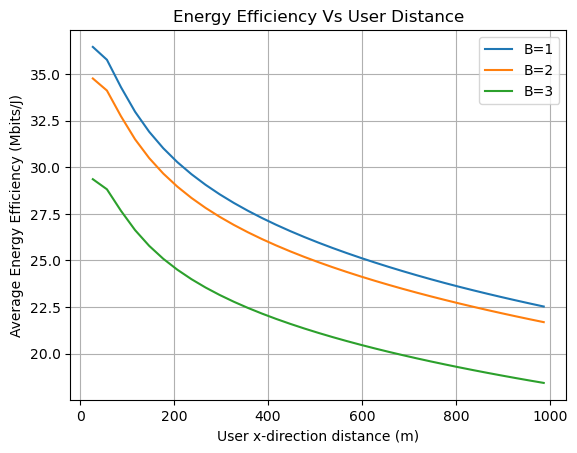

In [30]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_8.items():
    plt.plot(user_distances, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('User x-direction distance (m)')
plt.title('Energy Efficiency Vs User Distance')
plt.legend()
plt.grid(True)
plt.show()

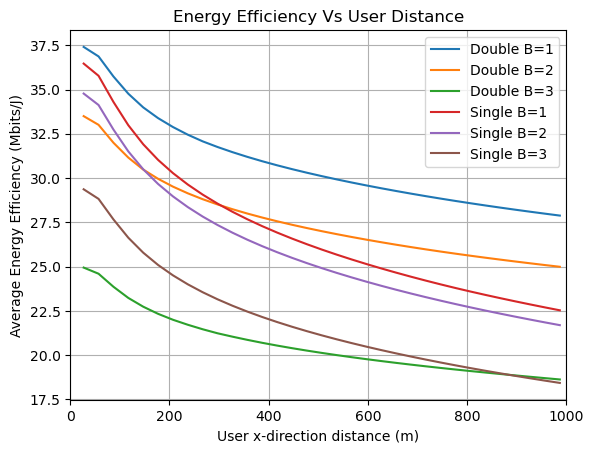

In [31]:
# Plots of practical cases
for B, average_energy_efficiency_1 in results_dict_4.items():
    plt.plot(user_distances, average_energy_efficiency_1, label=f'Double B={B}')

for B, average_energy_efficiency_1 in results_dict_8.items():
    plt.plot(user_distances, average_energy_efficiency_1, label=f'Single B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('User x-direction distance (m)')
plt.title('Energy Efficiency Vs User Distance')
plt.legend()
plt.grid(True)
plt.xlim(0, 1000)
plt.show()



In [32]:
user_distances_T = np.transpose(user_distances)
DB1 = np.transpose(results_dict_4[1])
DB2 = np.transpose(results_dict_4[2])
DB3 = np.transpose(results_dict_4[3])
SB1 = np.transpose(results_dict_8[1])
SB2 = np.transpose(results_dict_8[2])
SB3 = np.transpose(results_dict_8[3])

user_distances_T = user_distances_T.reshape(len(user_distances), 1)
DB1 = DB1.reshape(len(user_distances), 1)
DB2 = DB2.reshape(len(user_distances), 1)
DB3 = DB3.reshape(len(user_distances), 1)
SB1 = SB1.reshape(len(user_distances), 1)
SB2 = SB2.reshape(len(user_distances), 1)
SB3 = SB3.reshape(len(user_distances), 1)

stacked_array = np.hstack((user_distances_T, DB1, DB2, DB3, SB1, SB2, SB3))
stacked_array = np.array(stacked_array)

print(stacked_array.shape)

headings = ['User Distance', 'Double_B1', 'Double_B2', 'Double_B3', 'Single_B1', 'Single_B2', 'Single_B3']
np.savetxt('UserDistanceVsEE.csv', stacked_array, delimiter=',', header=','.join(headings), comments='')



(33, 7)
